In [1]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input

In [12]:
IMG_SIZE = 224
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '../../Bai_4/data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../../Bai_4/data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess_input)
test_generator = test_datagen.flow_from_directory(
    '../../Bai_4/data/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
base_model = MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,687 (3.90 MB)

 Trainable params: 670,759 (2.56 MB)

 Non-trainable params: 350,928 (1.34 MB)

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Giảm learning rate nếu val_loss không giảm sau 2 epoch
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Lưu model tốt nhất
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Huấn luyện model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.3269 - loss: 1.7034
Epoch 1: val_loss improved from inf to 1.54111, saving model to best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 320s 439ms/step - accuracy: 0.3270 - loss: 1.7032 - val_accuracy: 0.4503 - val_loss: 1.5411 - learning_rate: 0.0010
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4906 - loss: 1.3739
Epoch 2: val_loss improved from 1.54111 to 1.38586, saving model to best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 287s 400ms/step - accuracy: 0.4906 - loss: 1.3738 - val_accuracy: 0.4910 - val_loss: 1.3859 - learning_rate: 0.0010
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5359 - loss: 1.2623
Epoch 3: val_loss improved from 1.38586 to 1.26457, saving model to best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 330s 459ms/step - accuracy: 0.5359 - loss: 1.2623 - val_accuracy: 0.5240 - val_loss: 1.2646 - learning_rate: 0.0010
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/s

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7178/7178 ━━━━━━━━━━━━━━━━━━━━ 71s 10ms/step - accuracy: 0.5660 - loss: 1.1460
Test Accuracy: 61.63%
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step
y_true[:10]: [0 0 0 0 0 0 0 0 0 0]
y_pred_classes[:10]: [0 0 5 0 0 4 0 0 0 0]


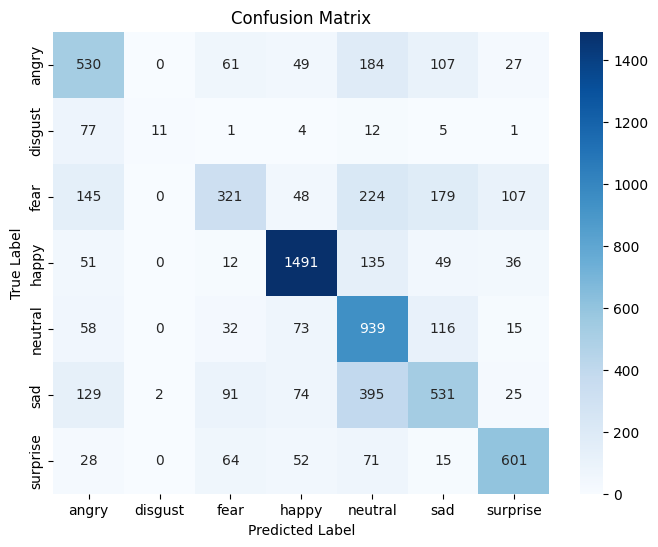

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model_V4.keras')
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("y_true[:10]:", y_true[:10])
print("y_pred_classes[:10]:", y_pred_classes[:10])  # ✅ đúng


y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(test_generator.filenames) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step
Average Inference Time: 10.15 ms/image


In [ ]:
# Model Size
model.save("best_model_V4.keras")
size_mb = os.path.getsize("best_model_V4.keras") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.58 MB


In [16]:
from sklearn.metrics import f1_score

# F1-Score macro (trung bình đều các lớp)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# F1-Score micro (toàn bộ TP, FP, FN gộp lại)
f1_micro = f1_score(y_true, y_pred_classes, average='micro')

# F1-Score weighted (có tính đến số lượng mẫu từng lớp)
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-Score (Macro): {f1_macro * 100:.2f}%")
print(f"F1-Score (Micro): {f1_micro * 100:.2f}%")
print(f"F1-Score (Weighted): {f1_weighted * 100:.2f}%")

F1-Score (Macro): 53.46%
F1-Score (Micro): 61.63%
F1-Score (Weighted): 60.59%
